In [1]:
# Brian Shula
# Septemer 24, 2023
# Image to Abaqus contour plot
# KMeans clustering to reduce image colors
# Material property values and load choice produce desired contour plot


# !!!!!!!!!!!     Caution - 1 element created per image pixel - large images = very large models !!!!!!!!!!


import PIL
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from tensorflow.keras.layers import Conv2D
import pandas as pd
import os

In [2]:
#Load Image and convert to numpy array
img = Image.open('HS.png', 'r')
array = np.asarray(img)

In [3]:
array.shape

(448, 357, 4)

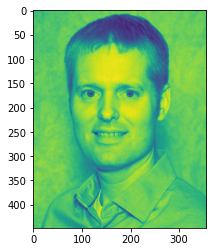

In [4]:
#image is in RGB
#plot image red channel
plt.imshow(array[:,:,0])

In [5]:
#arrange color channels into 1d arrays
arrays = [array[:,:,0].reshape(array.shape[0]*array.shape[1]),
          array[:,:,1].reshape(array.shape[0]*array.shape[1]),
          array[:,:,2].reshape(array.shape[0]*array.shape[1])]

In [6]:
#Transpose and normalize for KMeans Clustering
arrays = np.array(arrays).T
arrays = arrays/255.
arrays.shape

(159936, 3)

In [7]:
#Define and fit KMeans; prime numbers are good :)
n_clusters = 17
kmeans = KMeans(n_clusters=n_clusters, random_state=41)
clusters = kmeans.fit(arrays)

c:\users\brian\appdata\local\programs\python\python39\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [8]:
#Get RGB of n_clusters colors for reduced color image
colors = clusters.cluster_centers_*255

In [9]:
#Reshape cluster assignment for each pixel values into shape of input image
regions = clusters.labels_.reshape(array.shape[0],array.shape[1])

In [10]:
#Create empty array and assign cluster
px = np.zeros((len(clusters.labels_),3))
for i, color in enumerate(clusters.labels_):
    px[i] = colors[color]

px = px.reshape(array.shape[0],array.shape[1],3)

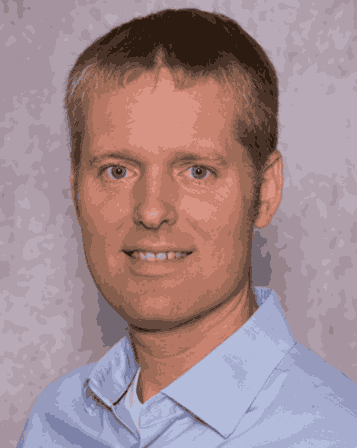

In [11]:
#Plot reduced color image
newimg = Image.fromarray(np.array(px).astype(np.uint8))
newimg

In [12]:
#Element sets dictionary - for assigning material properties later
esets = {n:{'cluster_center':'', 'elements':[]} for n in range(len(clusters.cluster_centers_))}

In [13]:
#function for writing nsets, elsets to input file
def write_set(type,file, name, elements):
    lines = []
    if type.lower() == 'elset':
        lines.append('*elset, elset='+name+'\n')
    elif type.lower() == 'nset':
        lines.append('*nset, nset='+name+'\n')
        
    line = ''
    linecount = 0
    for e in elements:
        line = line + str(e)
        linecount = linecount+1
        if linecount == 16:
            #full line, last and not last
            line = line+'\n'
            lines.append(line)
            linecount = 0
            line = ''
        else: 
            if e == elist[-1]:
                #last element, no comma, new line
                line = line+'\n'
                lines.append(line)
            else:
                #not last element, not new line
                line = line+',\t'

    #write elset
    for line in lines:
        file.write(line)

In [14]:
#create .inp file w/ quad mesh per pixel
jobname = 'ThermalStrain'
dst = open(jobname + '.inp', 'w')

#repository for contents to be written to file
lines = []
lines.append('**Oprhan Mesh \n')

#BC nodes
disp_x = []
disp_y = []

#Create Nodes
lines.append('*Node\n')
count = 1
for i in range(array.shape[0]+1):
    for j in range(array.shape[1]+1):
        line = '\t'+str(count)+',\t'+str(j)+'.,\t'
        line = line+str(-i+array.shape[0]) #flip into first quadrant of FEA
        line = line+'.,\t0.0\n'
        lines.append(line)
        count = count+1

        if j == 0:
            disp_x.append(count)
        if i == 0:
            disp_y.append(count)

nodecount=count

#write nodes
for line in lines:
    dst.write(line)

In [15]:
#Create Quads
lines=[]
lines.append('**Elements\n')
lines.append('*Element, Type=CPS4R\n')

count=1
for i in range(array.shape[0]): 
    for j in range(array.shape[1]):
        #
        n1=(j + 1) + i * (array.shape[1] + 1)
        n2=(j + 2) + i * (array.shape[1] + 1)
        n3=(j + 2) + (i + 1)*(array.shape[1] + 1)
        n4=(j + 1) + (i + 1)*(array.shape[1] + 1)
        lines.append(str(count) + ',\t'+str(n1) + ',\t' + str(n4) + ',\t' + str(n3) + ',\t' + str(n2) + '\n')

        #append to element set list
        esets[regions[i,j]]['elements'].append(count)  
        count=count+1

#write elements
for line in lines:
    dst.write(line)

In [16]:
line='**Element Sets\n'
dst.write(line)
for key in esets.keys():
    esets[key]['cluster_center'] = colors[key].astype(int)
    elist = esets[key]['elements']
    name = 'region_' + str(key)
    write_set('elset', dst, name, elist)

#
# BC Sets
#All
line = '*nset, nset=All, generate\n'
dst.write(line)
line='1, ' + str(nodecount) + ', 1\n'
dst.write(line)

#disp BCs   
write_set('nset', dst, 'disp_x', disp_x)
write_set('nset',dst, 'disp_y', disp_y)

In [17]:
#Sort colors for color spectrum, alpha assignment; store corresponding region key
spectrum = []
for key in esets.keys():
    spectrum.append(esets[key]['cluster_center'])

In [18]:
#Create dataframe for sorting by colors, color ratios to build contour spectrum
colordict={'r':[], 'g':[], 'b':[]}
for c in spectrum:
    colordict['r'].append(c[0])
    colordict['g'].append(c[1])
    colordict['b'].append(c[2])

#Create dataframe from dict
df_spectrum=pd.DataFrame(colordict)

#additional columns of color ratios
df_spectrum['rg'] = df_spectrum['r'] / df_spectrum['g']
df_spectrum['rb'] = df_spectrum['r'] / df_spectrum['b']
df_spectrum['bg'] = df_spectrum['b'] / df_spectrum['g']

In [19]:
#Spectrum color sorting - had to be seen visually to determine rules
#repository for spectrum sequence
sortedspectrum = []

#First batch - rg>1.0, increasing blue
df_temp = df_spectrum[df_spectrum['rg'] < 1.0].sort_values(by = 'b', ascending=True)

for index, row in df_temp.iterrows():
    rgb = [row['r'],row['g'],row['b']]
    sortedspectrum.append(rgb)

#Second batch - 1.0<rg<1.2, decreasing red
df_temp = df_spectrum[(df_spectrum['rg'] < 1.2) & (df_spectrum['rg'] > 1.0) ].sort_values(by = 'r', ascending=False)

for index, row in df_temp.iterrows():
    rgb = [row['r'],row['g'],row['b']]
    sortedspectrum.append(rgb)


#Third batch - rg>1.3, decreasing red
df_temp = df_spectrum[df_spectrum['rg'] > 1.3].sort_values(by = 'r', ascending=False)

for index, row in df_temp.iterrows():
    rgb=[row['r'],row['g'],row['b']]
    sortedspectrum.append(rgb)

In [20]:
#Generate list of region ids by order in spectrum
#use for calculation of alpha
region_index=[]
for key in esets.keys():
    count=0
    for speccol in sortedspectrum:
        #Find matching sets
        if esets[key]['cluster_center'][0] == speccol[0] and esets[key]['cluster_center'][1] == speccol[1] and esets[key]['cluster_center'][2] == speccol[2]:
            region_index.append(count)
            continue
        count=count+1
        

In [21]:
#Solid Sections
lines = []
lines.append('** Solid Section assigments\n')

for key in esets.keys():
    lines.append('*solid section, elset=region_' + str(key) + ', material=mat_' + str(key)+'\n')
    lines.append(',\n')

lines.append('**Material definitions\n')

for key in esets.keys():
    #Mateiral definition
    lines.append('*material, name=mat_' + str(key) + '\n')

    #Fictitious combination of E, nu, and alpha
    #Elastic
    lines.append('*Elastic\n')
    lines.append(' 10000000., 0.33\n')

    #Expansion
    lines.append('*expansion, zero=70\n')
    #calculate alpha
    alphamin = 5e-6
    alphamax = 7e-6
    alpha = ((alphamax - alphamin) * (region_index[key] + 1) / n_clusters) + alphamin
    lines.append(str(alpha)+'\n')

#write material info
for line in lines:
    dst.write(line)

In [22]:
#Step definition lines
lines=['** STEP: Step-1\n',
    '*Step, name=Step-1, nlgeom=NO\n',
    '*Static\n',
    '1., 1., 1e-05, 1.\n',
    '*Temperature\n',
    'All, 200.\n',
    '*Output, field\n',
    '*Node Output\n',
    'CF, RF, U\n',
    '*Element Output, directions=YES\n',
    'LE, PE, PEEQ, PEMAG, S, THE\n',
    '*Output, history, variable=PRESELECT\n',
    '*End Step\n']

for line in lines:
    dst.write(line)

In [23]:
#Close input fie
dst.close()

In [24]:
#These next blocks generate the Abaqus Viewer session commands to create the custom contour scale
#Recommended to turn off the element outlines under Options --> Common --> Visible Edges = Feature Edges

#Solve model, open ODB, and paste generated command into Python console for custom contour spectrum
#Generate line for custom color spectrum in Abaqus
line='session.Spectrum(name="ImageSpectrum", colors =('
for c in sortedspectrum:

    #determine Hex from INT RGB values
    r = hex(int(c[0]))
    g = hex(int(c[1]))
    b = hex(int(c[2]))
    rgbcode = '\'#' + r[2:] + g[2:] + b[2:]

    #Assemble line with formatting
    line = line + rgbcode + '\', '

#More formatting
line = line + '))'

print(line)

session.Spectrum(name="ImageSpectrum", colors =('#7d82a8', '#969bbd', '#a6accd', '#b3bcdb', '#b8abb7', '#af9fab', '#a5939f', '#958389', '#736772', '#d79484', '#c78370', '#b57664', '#9f6b59', '#845d4d', '#664a3f', '#493227', '#2c1b11', ))


In [25]:
#Command to set activate spectrum
line = 'session.viewports[\'Viewport: 1\'].odbDisplay.contourOptions.setValues(spectrum=\'ImageSpectrum\')'
print(line)

session.viewports['Viewport: 1'].odbDisplay.contourOptions.setValues(spectrum='ImageSpectrum')


In [26]:
#Command to set number of contour bands equal to number of clusters used
line = 'session.viewports[\'Viewport: 1\'].odbDisplay.contourOptions.setValues(numIntervals=' + str(n_clusters) + ')'
print(line)

session.viewports['Viewport: 1'].odbDisplay.contourOptions.setValues(numIntervals=17)
